In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

In [58]:
fama_french_raw = pd.read_csv("data/05_df_ff_info.csv")
fundamentals_raw = pd.read_csv("data/funda.csv")
stocks_raw = pd.read_csv("data/monthlystocks.csv")

In [59]:
def clean_fundamentals(fundamentals):
    fundamentals = fundamentals[(fundamentals["exchg"]>=11) & (fundamentals["exchg"]<=19)]
    fundamentals = fundamentals[fundamentals["curcd"] == "USD"]
    fundamentals = fundamentals[fundamentals["indfmt"] == "INDL"]
    fundamentals = fundamentals[fundamentals["fic"] == "USA"]
    fundamentals = fundamentals[(fundamentals["sic"] <= 5999) | (fundamentals["sic"] >= 7000)]

    fundamentals['datadate'] = pd.to_datetime(fundamentals['datadate'])

    fundamentals['datadate'] = fundamentals['datadate'] + pd.DateOffset(months=3)

    fundamentals['year'] = fundamentals['datadate'].dt.year

    fundamentals['xrd'] = fundamentals['xrd'].fillna(0)

    fundamentals = fundamentals.sort_values(by=['datadate','LPERMNO']).reset_index(drop=True)

    return fundamentals

In [60]:
def clean_stocks(stocks_input):
    
    stocks = stocks_input.copy()
    stocks = stocks[pd.to_numeric(stocks['RET'], errors='coerce').notnull()]

    stocks['RET'] = pd.to_numeric(stocks['RET'])

    stocks["date"] = pd.to_datetime(stocks["date"])

    stocks = stocks[(stocks["RET"] < 500)]

    stocks = stocks[(stocks["RET"] > -100)]

    stocks = stocks[(stocks["SHROUT"] > 0)]

    stocks["PRC"] = abs(stocks["PRC"])

    stocks["PRC"] = stocks["PRC"].replace({0:np.nan})

    stocks["SHROUT"] = stocks["SHROUT"].fillna(method="ffill")

    stocks = stocks.dropna(subset=["SHROUT", "PRC"])

    stocks["Market Cap"] = stocks["PRC"] * stocks["SHROUT"]

    stocks.rename({"date": "datadate", "PERMNO":"LPERMNO"}, axis=1, inplace=True)

    stocks['datadate'] = stocks['datadate'] + MonthEnd(0)

    stocks["year"] = [i.year if i >= pd.Timestamp(year=i.year, month=4, day=1) else i.year-1 for i in stocks["datadate"]]

    return stocks

In [61]:
def get_rd_capital(fundamentals):

    weights = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

    rd_cap = fundamentals.groupby("LPERMNO")["xrd"].rolling(5).apply(lambda x: np.sum(weights*x)).reset_index(level=[0,1])[["level_1", "xrd"]].set_index('level_1').rename(columns={"xrd": "RDC"})

    fundamentals = pd.merge(fundamentals, rd_cap, left_index=True, right_index=True)

    fundamentals = fundamentals.dropna(subset=['RDC'])
    fundamentals = fundamentals[["LPERMNO", "datadate", "RDC"]]

    return fundamentals

In [62]:
def split_rd_firms(fundamentals):
    
    non_rd_firms_fund = fundamentals[fundamentals["RDC"] == 0].copy()
    rd_firms_fund = fundamentals[fundamentals["RDC"] > 0].copy()

    rd_firms_fund["datadate"] = [pd.Timestamp(year=i.year+1,month=3, day=31) if i > pd.Timestamp(year=i.year, month=4, day=1) else pd.Timestamp(year=i.year,month=3, day=31)  for i in rd_firms_fund["datadate"]]
    non_rd_firms_fund["datadate"] = [pd.Timestamp(year=i.year+1,month=3, day=31) if i > pd.Timestamp(year=i.year, month=4, day=1) else pd.Timestamp(year=i.year,month=3, day=31)  for i in non_rd_firms_fund["datadate"]]

    return rd_firms_fund, non_rd_firms_fund

In [63]:
def merge_stock_fundamentals(rd_firms_fund, non_rd_firms_fund, stocks):
    rd_firms = pd.merge(stocks[["datadate", "Market Cap", "LPERMNO"]], rd_firms_fund, on = ["LPERMNO", "datadate"], how="right")
    non_rd_firms = pd.merge(stocks[["datadate", "Market Cap", "LPERMNO"]], non_rd_firms_fund, on = ["LPERMNO", "datadate"], how="right")

    rd_firms.dropna(inplace=True)
    non_rd_firms.dropna(inplace=True)
    
    return rd_firms, non_rd_firms


In [70]:
def remove_top_1000(rd_firms_in, non_rd_firms_in):

        rd_firms_in['id'] = ["rd-"+str(i) for i in range(rd_firms_in.shape[0])]
        non_rd_firms_in['id'] = ["nonrd-"+str(i) for i in range(non_rd_firms_in.shape[0])]
        firms = pd.concat([rd_firms_in, non_rd_firms_in])
        
        temp_1 = firms.reset_index(drop=True).sort_values('Market Cap',ascending = False)
        temp_2 = temp_1.groupby("year").head(1000).sort_values("year") 

        top_firms = temp_1[temp_1.index.isin(temp_2.index)]

        removed_top_rd = rd_firms_in[~rd_firms_in["id"].isin(top_firms["id"])]
        
        removed_top_non_rd = non_rd_firms_in[~non_rd_firms_in["id"].isin(top_firms["id"])]   


        return removed_top_rd, removed_top_non_rd    


def bin_firms(rd_firms, non_rd_firms, remove_1000=False):

    if remove_1000:
        rd_firms, non_rd_firms = remove_top_1000(rd_firms.copy(), non_rd_firms.copy())


    rd_firms["RDC/Market Cap"] = rd_firms["RDC"] / rd_firms["Market Cap"]
    rd_firms['bins'] = rd_firms.groupby(['datadate'])['RDC/Market Cap'].transform(lambda x: pd.qcut(x, 5, labels=["L", "2", "3", "4", "H"]))
    rd_firms["year"] = rd_firms["datadate"].dt.year
    non_rd_firms["year"] = non_rd_firms["datadate"].dt.year
    non_rd_firms["bins"] = "Non R&D"

    firms = pd.concat([rd_firms, non_rd_firms])

    return firms, rd_firms, non_rd_firms
    
   

In [71]:
def get_monthly_returns(firms, stocks, value_weighted = True):
    
    stocks_w_bins = pd.merge(stocks, firms[["LPERMNO", "bins", "year"]], on=["LPERMNO", "year"], how="inner")

    if value_weighted:

        stocks_w_bins["Market Cap Shifted"] = stocks_w_bins.groupby(["LPERMNO"])["Market Cap"].shift(1)
        stocks_w_bins.dropna(subset=["Market Cap Shifted"], inplace=True)
        
        stocks_w_bins = pd.merge(stocks_w_bins, stocks_w_bins.groupby(["datadate", "bins"])["Market Cap Shifted"].sum().reset_index(), on=["datadate", "bins"], how="inner").rename({"Market Cap Shifted_y": "Sum Market Cap Shifted", "Market Cap Shifted_x": "Market Cap Shifted"}, axis=1)
        stocks_w_bins["weight"] = stocks_w_bins["Market Cap Shifted"] / stocks_w_bins["Sum Market Cap Shifted"]
        stocks_w_bins["stock return"] = stocks_w_bins["RET"] * stocks_w_bins["weight"]

        monthly_returns = stocks_w_bins.groupby(["datadate","bins"])["stock return"].sum().reset_index()


    else:
        stocks_w_bins = pd.merge(stocks_w_bins, stocks_w_bins.groupby(["datadate", "bins"])["RET"].count().reset_index().rename({"RET":"Count in Bin for Month"}, axis=1))
        stocks_w_bins["equal weight"] = 1 /stocks_w_bins["Count in Bin for Month"] 
        stocks_w_bins["stock return"] = stocks_w_bins["RET"] * stocks_w_bins["equal weight"]
    
    monthly_returns = stocks_w_bins.groupby(["datadate","bins"])["stock return"].sum().reset_index()    
    return monthly_returns

In [72]:
def clean_fama_french(fama_french):
    fama_french["Date"] = pd.to_datetime(fama_french["Date"])
    fama_french["Date"] = fama_french["Date"] + MonthEnd(0)

    return fama_french

def get_excess_returns(monthly_returns, fama_french):
    monthly_returns = pd.merge(monthly_returns, fama_french[["Date", "RF"]], left_on=["datadate"], right_on=["Date"])
    monthly_returns["Excess Returns"] = monthly_returns["stock return"] - monthly_returns["RF"]
    monthly_returns["Excess Returns"] = monthly_returns["Excess Returns"] * 100
    
    return monthly_returns
    

In [73]:
def get_results(monthly_returns):
    
    order = ["L", "2", "3", "4", "H", "Non R&D"]

    first_period = pd.Timestamp(year=1981, month=7, day=1)
    mid_period = pd.Timestamp(year=1999, month=12, day=31)
    last_period = pd.Timestamp(year=2012, month=12, day=31)
    extra_period = pd.Timestamp(year=2021, month=12, day=31)


    full_period = monthly_returns[(monthly_returns["datadate"] >= first_period) & (monthly_returns["datadate"] <= last_period)].groupby("bins")["Excess Returns"].mean()[order]
    pre_2000 = monthly_returns[(monthly_returns["datadate"] >= first_period) & (monthly_returns["datadate"] <= mid_period)].groupby("bins")["Excess Returns"].mean()[order]
    post_2000 = monthly_returns[(monthly_returns["datadate"] > mid_period) & (monthly_returns["datadate"] <= last_period)].groupby("bins")["Excess Returns"].mean()[order]
    extra = monthly_returns[(monthly_returns["datadate"] >= first_period) & (monthly_returns["datadate"] <= extra_period)].groupby("bins")["Excess Returns"].mean()[order]

    columns=['L', '2', '3', '4', 'H', 'Non R&D']

    

    results = pd.DataFrame({c: pd.Series(dtype="float") for c in columns})

    results.loc[len(results.index)] = full_period
    results.loc[len(results.index)] = pre_2000
    results.loc[len(results.index)] = post_2000
    results.loc[len(results.index)] = extra

    results.index = ["Full period", "Pre 2000", "Post 2000", "Full Through Dec 2021"]

    return results

In [74]:
def clean_data(stocks_raw, fundamentals_raw, fama_french_raw):
    stocks = clean_stocks(stocks_raw)
    fundamentals = clean_fundamentals(fundamentals_raw)
    fama_french = clean_fama_french(fama_french_raw)

    return stocks, fundamentals, fama_french
    


In [75]:
stocks, fundamentals, fama_french = clean_data(stocks_raw, fundamentals_raw, fama_french_raw)
fundamentals = get_rd_capital(fundamentals)
rd_firms_fund, non_rd_firms_fund = split_rd_firms(fundamentals)
rd_firms, non_rd_firms = merge_stock_fundamentals(rd_firms_fund, non_rd_firms_fund, stocks)
firms, rd_firms, non_rd_firms = bin_firms(rd_firms, non_rd_firms)

firms_wo_1000, rd_firms_wo_1000, non_rd_firms_wo_1000 = bin_firms(rd_firms, non_rd_firms, remove_1000=True)

,L,2,3,4,H,Non R&D
Full period,0.653925,0.771680,1.005758,1.277150,1.929399,0.948060
Pre 2000,0.745202,0.848916,1.091114,1.295915,1.940210,0.898827
Post 2000,0.529295,0.666222,0.889214,1.251529,1.914638,1.015283
Full Through Dec 2021,0.754317,0.883311,1.138147,1.318589,1.907781,0.999234


<AxesSubplot:title={'center':'Value Weighted'}, xlabel='Bin', ylabel='Average Percent Return'>

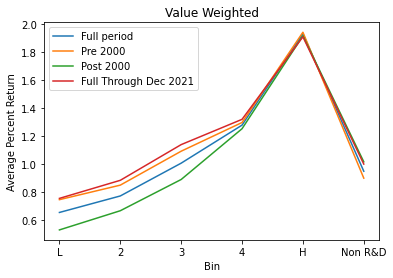

In [76]:
equal_monthly_returns = get_monthly_returns(firms, stocks, value_weighted=False)
equal_monthly_returns = get_excess_returns(equal_monthly_returns, fama_french)

equal_results = get_results(equal_monthly_returns)
display(equal_results)
equal_results.T.plot(ylabel="Average Percent Return", xlabel="Bin", title="Value Weighted")

,L,2,3,4,H,Non R&D
Full period,0.607867,0.782003,0.765210,1.041920,1.162209,0.652561
Pre 2000,1.034415,1.190198,1.057770,1.244044,1.239480,0.925109
Post 2000,0.025465,0.227276,0.367629,0.765943,1.056705,0.280428
Full Through Dec 2021,0.706362,0.987578,0.936286,1.251671,1.333370,0.732070


<AxesSubplot:title={'center':'Value Weighted'}, xlabel='Bin', ylabel='Average Percent Return'>

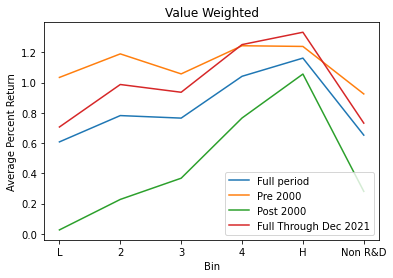

In [77]:
value_monthly_returns = get_monthly_returns(firms, stocks, value_weighted=True)
value_monthly_returns = get_excess_returns(value_monthly_returns, fama_french)

value_results = get_results(value_monthly_returns)
display(value_results)
value_results.T.plot(ylabel="Average Percent Return", xlabel="Bin", title="Value Weighted")

,L,2,3,4,H,Non R&D
Full period,0.532900,0.648375,0.961695,1.173562,1.692797,0.853584
Pre 2000,0.536186,0.717719,1.015820,1.140310,1.458516,0.724243
Post 2000,0.528413,0.554138,0.888142,1.218965,2.011179,1.030185
Full Through Dec 2021,0.637497,0.799676,1.113842,1.346693,1.722348,0.923622


<AxesSubplot:title={'center':'Value Weighted'}, xlabel='Bin', ylabel='Average Percent Return'>

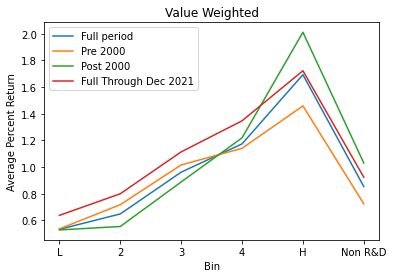

In [78]:
equal_monthly_returns = get_monthly_returns(firms_wo_1000, stocks, value_weighted=True)
equal_monthly_returns = get_excess_returns(equal_monthly_returns, fama_french)

equal_results = get_results(equal_monthly_returns)
display(equal_results)
equal_results.T.plot(ylabel="Average Percent Return", xlabel="Bin", title="Value Weighted")